In [1]:
import sys
sys.path[0] = ('/home/labs/waic/omrik/DNN-Challenge')
from fastai.vision import *
import pre
import resample

root = Path('../data').resolve()
train = root / 'train'
val = root / 'val'

In [2]:
def normalize_time(series):
    # 1440 minutes in a day
    normalized = (series.hour * 60 + series.minute) / 1440
    return normalized

def get_data(data_dir):
    cgm, meals = pre.get_dfs(data_dir)
    meals = resample.resample_meals(cgm, meals, 15)
    meals = pd.concat((meals, cgm), axis=1)
    meals['time'] = normalize_time(meals.index.get_level_values('Date'))
    cgm, y = pre.build_cgm(cgm)
    return cgm, meals, y

class ContData(Dataset):
    def __init__(self, cgm, meals, y):
        self.cgm = cgm
        self.meals = meals
        self.y = y
        
    def __len__(self):
        return len(self.cgm)
    
    def __getitem__(self, i):
        index = self.meals.index.get_loc(self.cgm.index[i])
        values = self.meals[index-48:index+1].values
        target = self.y.iloc[i].values
        x, y = torch.tensor(values, dtype=torch.float), torch.tensor(target, dtype=torch.float)
        return x, y


In [3]:
train_data = get_data(train)
val_data = get_data(val)

/home/labs/waic/omrik/DNN-Challenge/pre.py:73: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  X = X.loc[y.index].dropna(how='any', axis=0)


In [4]:
train_ds = ContData(*train_data)
val_ds = ContData(*val_data)
data = DataBunch.create(train_ds, val_ds, bs=512)
data

DataBunch;

Train: <__main__.ContData object at 0x7f458aac7470>;

Valid: <__main__.ContData object at 0x7f458aac7e80>;

Test: None

In [5]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Linear(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input)
        output = embedded
        output, hidden = self.gru(output[None], hidden)
        return output[0], hidden

    def initHidden(self, bs, device):
        return torch.zeros(1, bs, self.hidden_size, device=device)


In [6]:
MAX_LENGTH = 49

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size=1, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Linear(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(self.attn(torch.cat((embedded, hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights[:, None], encoder_outputs)

        output = torch.cat((embedded, attn_applied[:, 0]), 1)
        output = self.attn_combine(output)

        output = F.relu(output)
        output, hidden = self.gru(output[None], hidden)

        output = self.out(output[0])
        return output, hidden, attn_weights

    def initHidden(self, bs, device):
        return torch.zeros(1, bs, self.hidden_size, device=device)

In [7]:
class Seq2Lin(Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.encoder = EncoderRNN(input_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, 8)

        
    def forward(self, input):
        device = input.device
        bs = input.shape[0]
        input = input.transpose(0, 1)
        
        encoder_hidden = self.encoder.initHidden(bs, device)
        
        for ei in range(input.shape[0]):
            encoder_output, encoder_hidden = self.encoder(input[ei], encoder_hidden)

        out = self.decoder(encoder_output)
        return out

In [8]:
from metrics import Pearson

In [9]:
model = Seq2Lin(38, 128)
metrics = [mean_absolute_error, Pearson(val_ds.y)]
learner = Learner(data, model, loss_func=nn.MSELoss(), metrics=metrics)

epoch,train_loss,valid_loss,mean_absolute_error,pearson,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 7.59E-04


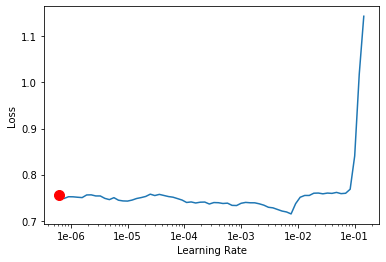

In [10]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [11]:
learner.fit_one_cycle(15, 1e-3)

epoch,train_loss,valid_loss,mean_absolute_error,pearson,time
0,0.471659,0.465282,0.466760,0.584968,02:42
1,0.451315,0.437707,0.449723,0.612085,02:42
2,0.427032,0.426909,0.446717,0.621855,02:43
3,0.428774,0.423764,0.448383,0.623913,02:43
4,0.419727,0.421156,0.438196,0.630421,02:43
5,0.416984,0.417053,0.440103,0.629492,02:43
6,0.407362,0.419581,0.446291,0.627728,02:43
7,0.402508,0.417733,0.444211,0.629943,02:43
8,0.392761,0.423180,0.445260,0.625615,02:43
9,0.382998,0.423993,0.444848,0.628441,02:44


In [12]:
learner.save('gru-lin-h128')